In [1]:
%load_ext jupyter_black

In [2]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy.stats import ttest_rel


def load_results(language, model_name):
    """Load retrieval results from a JSON file."""
    path = f"results/retrieval_results_{language}_{model_name}.json"
    with open(path, "r") as f:
        return json.load(f)


def evaluate_retrieval(results):
    """
    Evaluate retrieval metrics including Recall@K, MRR, Overlap@K, and Dropout counts.
    Returns a dictionary of evaluation metrics.
    """
    recall_at_active = {i: [] for i in range(1, 6)}
    recall_at_passive = {i: [] for i in range(1, 6)}
    mrr_active_scores = []
    mrr_passive_scores = []
    overlap_at = {1: 0, 3: 0, 5: 0}
    total_queries = 0

    for qid, retrieved in results.items():
        total_queries += 1
        correct = qid
        active_ranks = retrieved.get("active", [])
        passive_ranks = retrieved.get("passive", [])

        # Recall@K
        for k in range(1, 6):
            recall_at_active[k].append(1 if correct in active_ranks[:k] else 0)
            recall_at_passive[k].append(1 if correct in passive_ranks[:k] else 0)

        # MRR Active
        mrr_active_scores.append(
            1 / (active_ranks.index(correct) + 1) if correct in active_ranks else 0
        )
        # MRR Passive
        mrr_passive_scores.append(
            1 / (passive_ranks.index(correct) + 1) if correct in passive_ranks else 0
        )

        # Overlap@K
        for k in [1, 3, 5]:
            overlap = len(set(active_ranks[:k]) & set(passive_ranks[:k])) / k
            overlap_at[k] += overlap

    metrics = {
        "MRR_active": round(np.mean(mrr_active_scores), 4),
        "MRR_passive": round(np.mean(mrr_passive_scores), 4),
        "AvgOverlap@1": round(overlap_at[1] / total_queries, 4),
        "AvgOverlap@3": round(overlap_at[3] / total_queries, 4),
        "AvgOverlap@5": round(overlap_at[5] / total_queries, 4),
        "Total": total_queries,
    }

    metrics.update(
        {
            f"Recall@{k}_active": round(np.mean(recall_at_active[k]), 4)
            for k in range(1, 6)
        }
    )
    metrics.update(
        {
            f"Recall@{k}_passive": round(np.mean(recall_at_passive[k]), 4)
            for k in range(1, 6)
        }
    )

    return metrics

In [3]:
# Example usage
language = "en"
model_name = "BERT-multilingual"
results = load_results(language, model_name)
metrics = evaluate_retrieval(results)

print(f"📊 Evaluation for {model_name} [{language}]")
for k, v in metrics.items():
    print(f"{k}: {v}")

📊 Evaluation for BERT-multilingual [en]
MRR_active: 0.7246
MRR_passive: 0.6515
AvgOverlap@1: 0.612
AvgOverlap@3: 0.6253
AvgOverlap@5: 0.624
Total: 250
Recall@1_active: 0.632
Recall@2_active: 0.76
Recall@3_active: 0.82
Recall@4_active: 0.832
Recall@5_active: 0.86
Recall@1_passive: 0.528
Recall@2_passive: 0.696
Recall@3_passive: 0.74
Recall@4_passive: 0.788
Recall@5_passive: 0.852


In [4]:
# Define languages and models
languages = ["en", "ru"]
model_names = [
    "EuroBERT",
    "RuModernBERT",
    "RuModernBERT_USER2_FT",
    "BERT-multilingual",
    "EuroBERT_FT",
]

# Collect evaluation metrics
rows = []
for lang in languages:
    for model in model_names:
        try:
            path = f"results/retrieval_results_{lang}_{model}.json"
            if not os.path.exists(path):
                print(f"⚠️ Missing: {path}")
                continue

            results = load_results(lang, model)
            metrics = evaluate_retrieval(results)
            metrics["Model"] = model
            metrics["Language"] = lang
            rows.append(metrics)
        except Exception as e:
            print(f"❌ Failed to evaluate {lang} / {model}: {e}")

# Create the DataFrame
metrics_df = pd.DataFrame(rows)

# Optional: preview column names
print("✅ Metrics columns:", metrics_df.columns.tolist())

✅ Metrics columns: ['MRR_active', 'MRR_passive', 'AvgOverlap@1', 'AvgOverlap@3', 'AvgOverlap@5', 'Total', 'Recall@1_active', 'Recall@2_active', 'Recall@3_active', 'Recall@4_active', 'Recall@5_active', 'Recall@1_passive', 'Recall@2_passive', 'Recall@3_passive', 'Recall@4_passive', 'Recall@5_passive', 'Model', 'Language']


In [5]:
# Average MRR across languages
metrics_df["AvgMRR"] = metrics_df.groupby("Model")["MRR_active"].transform("mean")

# Sort by average MRR
metrics_df = metrics_df.sort_values("AvgMRR", ascending=False)

In [6]:
# Prepare MRR melt
mrr_melted = metrics_df.melt(
    id_vars=["Model", "Language"],
    value_vars=["MRR_active", "MRR_passive"],
    var_name="Metric",
    value_name="MRR_value",
)

# Extract 'Voice' from metric name
mrr_melted["Voice"] = mrr_melted["Metric"].apply(lambda x: x.split("_")[1].capitalize())

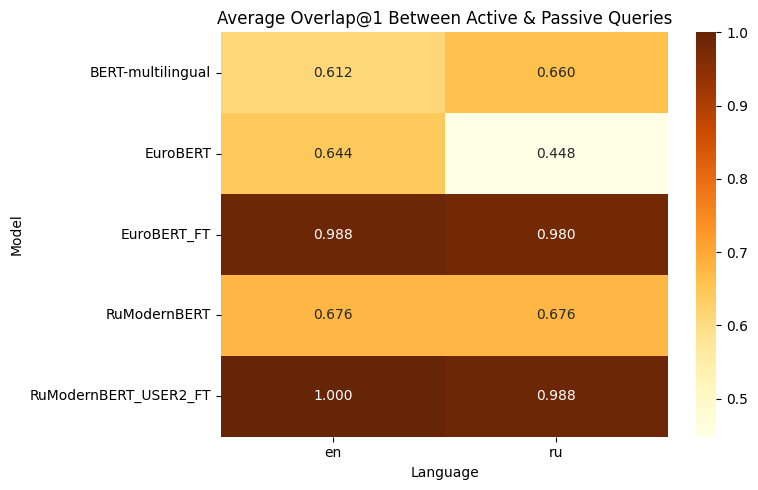

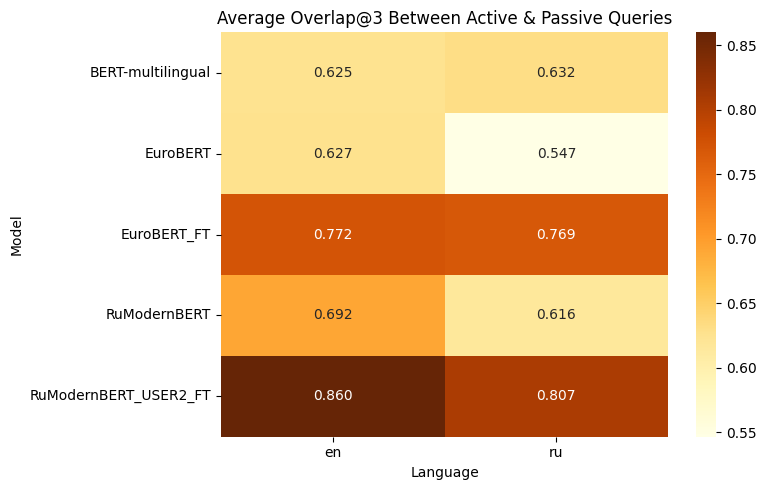

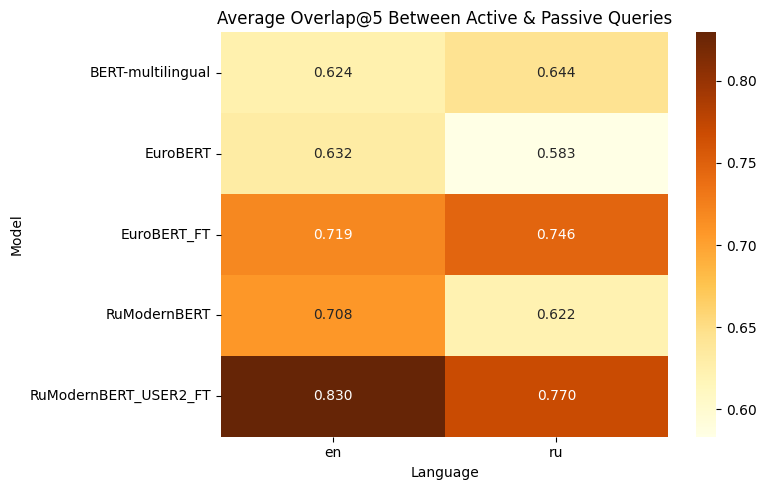

In [7]:
for k in [1, 3, 5]:
    pivot = metrics_df.pivot(
        index="Model", columns="Language", values=f"AvgOverlap@{k}"
    )
    plt.figure(figsize=(8, 5))
    sns.heatmap(
        pivot, annot=True, fmt=".3f", cmap="YlOrBr"
    )  # "crest", "YlOrBr"cividis"
    plt.title(f"Average Overlap@{k} Between Active & Passive Queries")
    plt.xlabel("Language")
    plt.ylabel("Model")
    plt.tight_layout()
    plt.show()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette

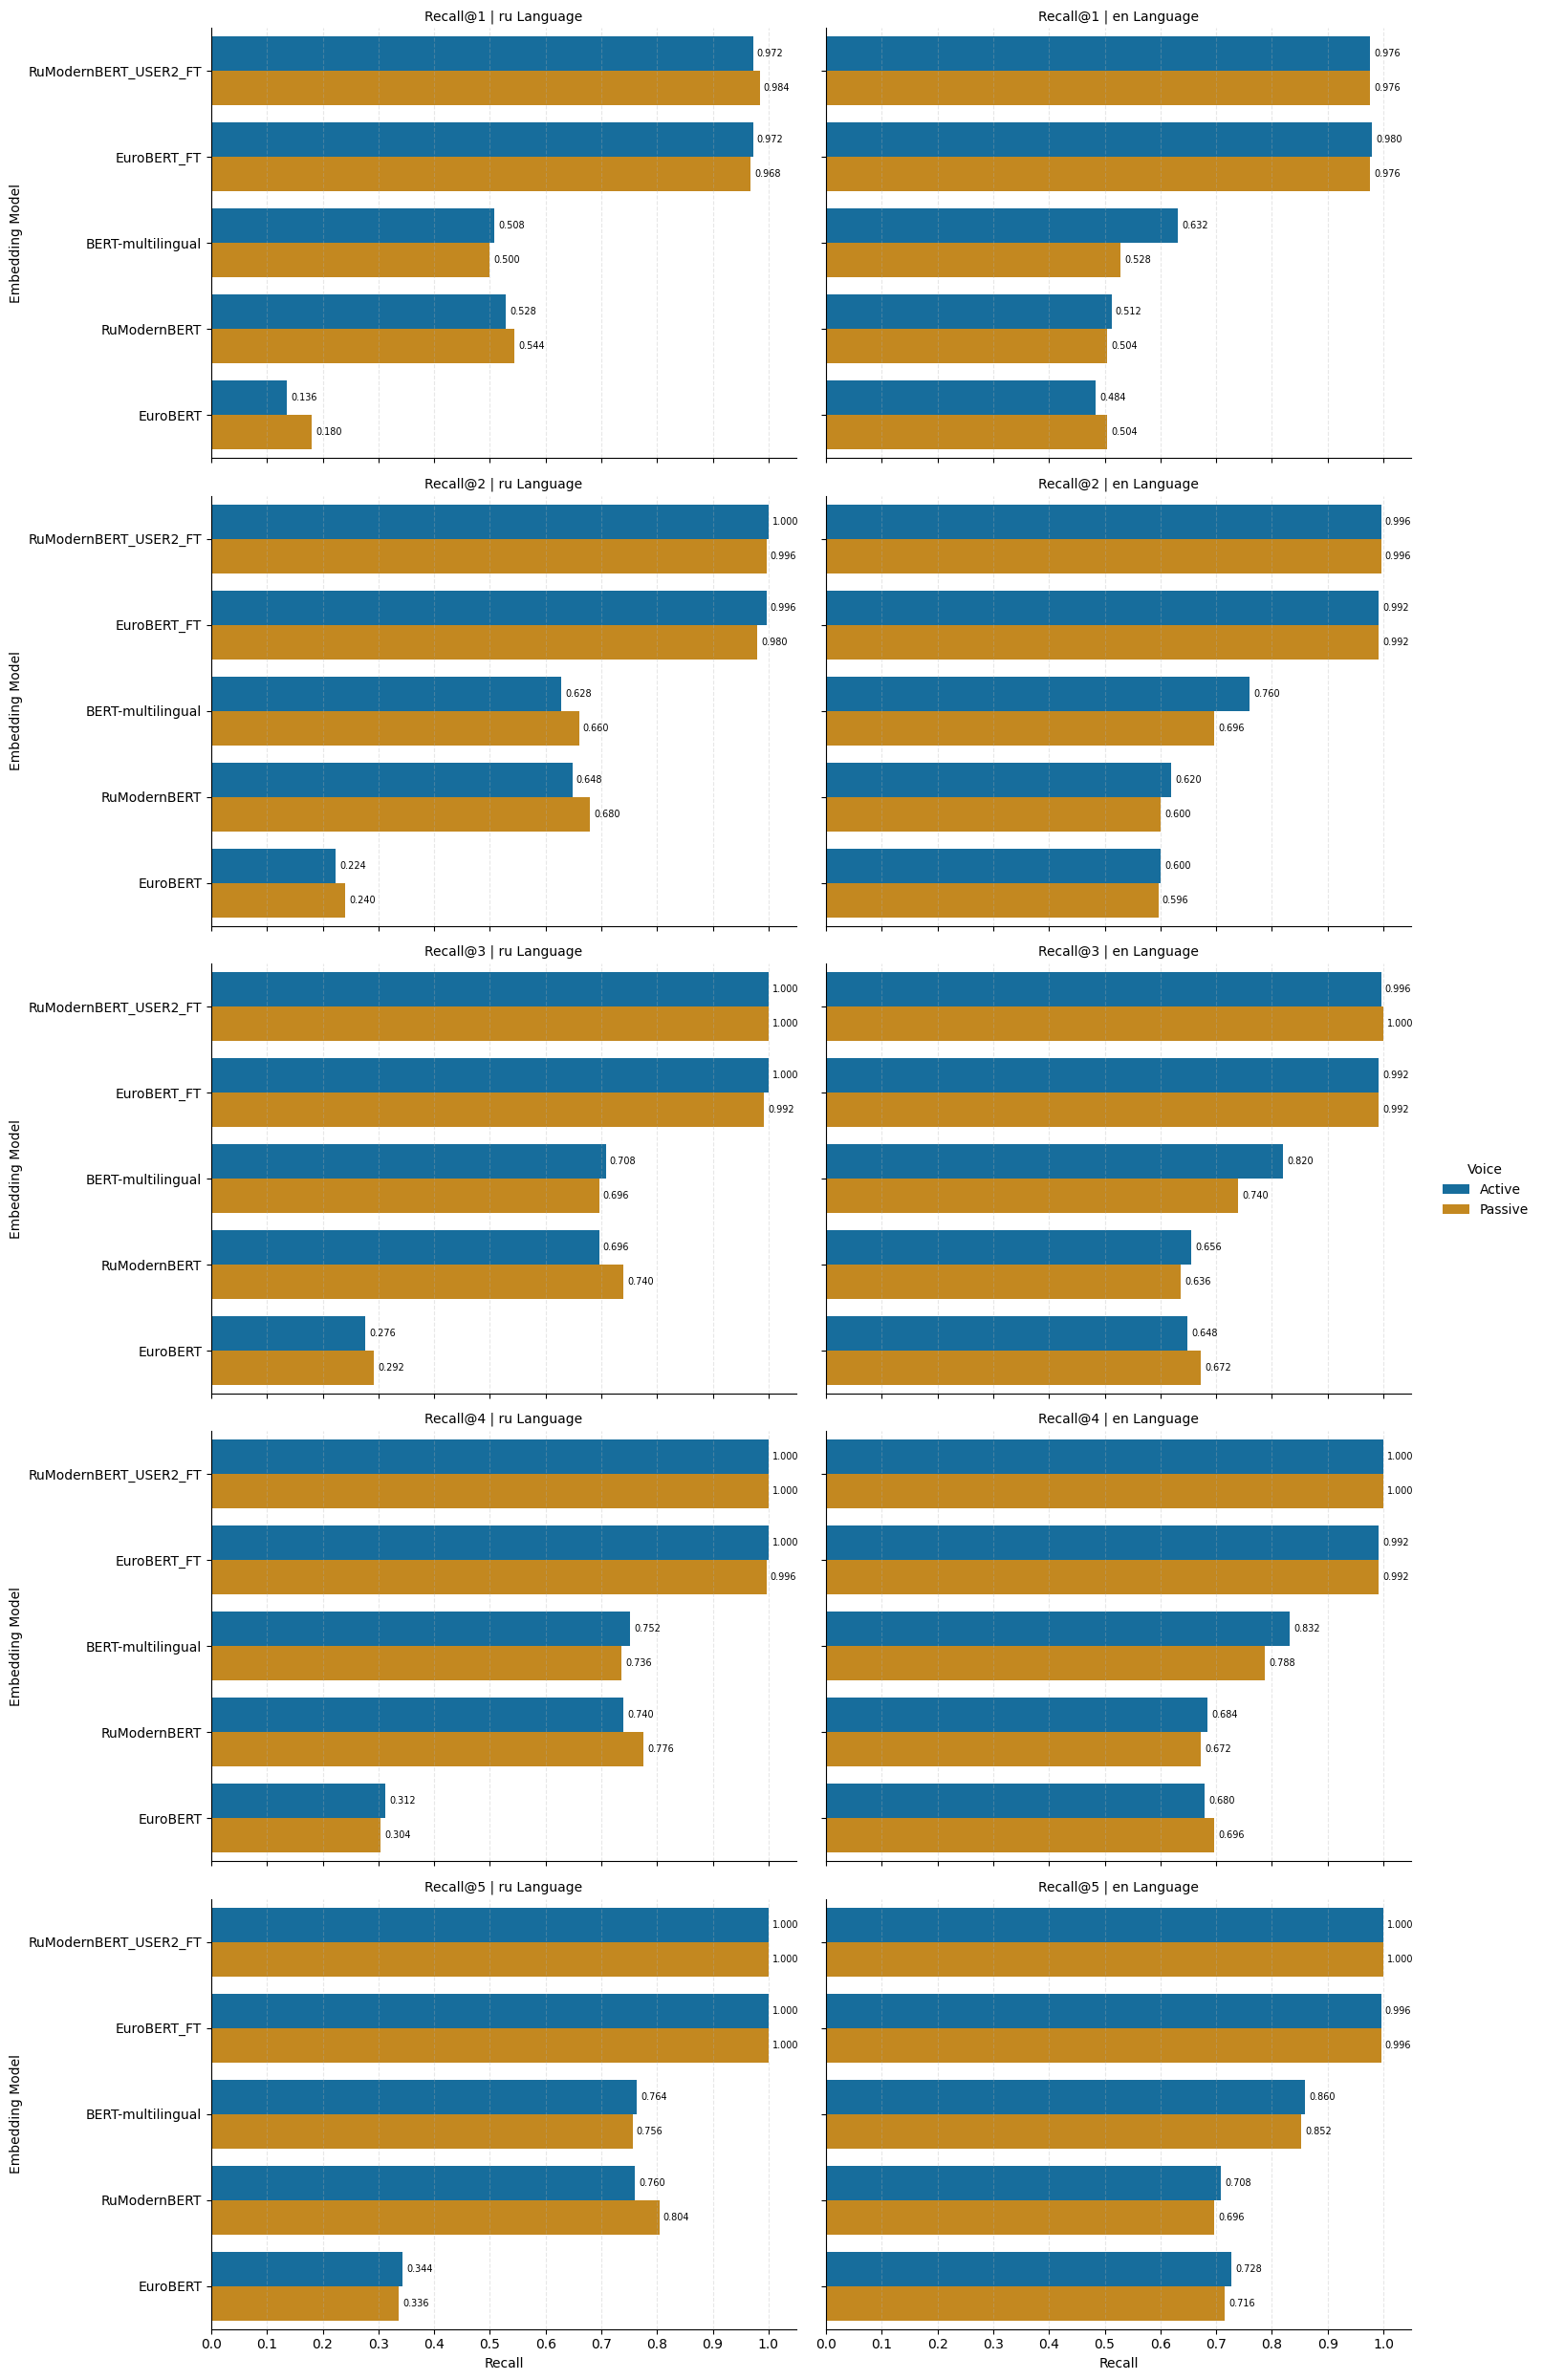

In [8]:
# Prepare Recall@K melt

# First: list of recall columns
recall_columns = []
for k in range(1, 6):
    recall_columns.append(f"Recall@{k}_active")
    recall_columns.append(f"Recall@{k}_passive")

# Melt dataframe
recall_melted = metrics_df.melt(
    id_vars=["Model", "Language"],
    value_vars=recall_columns,
    var_name="Metric",
    value_name="Recall_value",
)

# Split "Metric" column → into Voice and K
recall_melted["Voice"] = recall_melted["Metric"].apply(
    lambda x: "Active" if "active" in x else "Passive"
)
recall_melted["K"] = recall_melted["Metric"].apply(
    lambda x: int(x.split("@")[1].split("_")[0])
)

# Optional: sort models same as before
model_order = (
    recall_melted.groupby("Model")["Recall_value"]
    .mean()
    .sort_values(ascending=False)
    .index.tolist()
)

# === Plot: FacetGrid by Language, columns = K ===
g = sns.FacetGrid(
    recall_melted,
    col="Language",
    row="K",
    sharex=True,
    sharey=True,
    height=5,
    aspect=1.4,
)

# Barplot in each facet
g.map_dataframe(
    sns.barplot,
    y="Model",
    x="Recall_value",
    hue="Voice",
    order=model_order,
    palette=sns.color_palette("colorblind"),
)

# Titles and labels
g.set_titles(row_template="Recall@{row_name}", col_template="{col_name} Language")
g.set_axis_labels("Recall", "Embedding Model")
g.set(xlim=(0, 1.05))

# Gridlines and bar labels
for ax in g.axes.flat:
    ax.set_xticks(np.arange(0, 1.05, 0.1))
    ax.grid(axis="x", linestyle="--", alpha=0.3)
    for container in ax.containers:
        ax.bar_label(container, fmt="%.3f", label_type="edge", fontsize=7, padding=3)

# Add legend
g.add_legend(title="Voice", bbox_to_anchor=(1, 0.5), loc="center left")

# Final layout
plt.tight_layout()
plt.show()

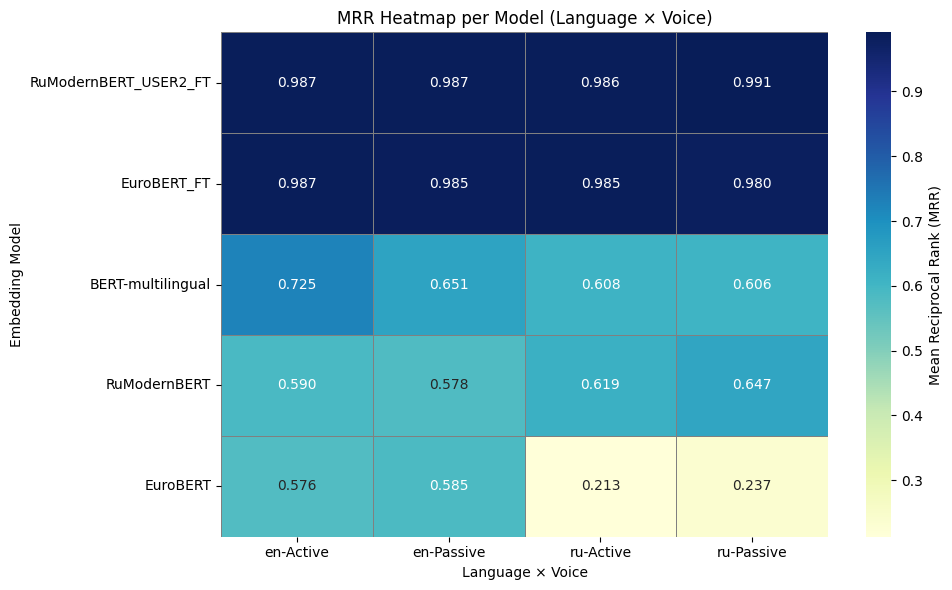

In [9]:
# Pivot the melted DataFrame
heatmap_data = mrr_melted.pivot_table(
    index="Model", columns=["Language", "Voice"], values="MRR_value"
)

# Sort models by average performance (optional)
heatmap_data = heatmap_data.sort_values(
    by=heatmap_data.columns.tolist(), ascending=False
)

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "Mean Reciprocal Rank (MRR)"},
)

plt.title("MRR Heatmap per Model (Language × Voice)")
plt.ylabel("Embedding Model")
plt.xlabel("Language × Voice")
plt.tight_layout()
plt.show()